# Задача

Продакт-менеджер Василий попросил вас проанализировать совершенные покупки и ответить на следующие вопросы:

1. Сколько у нас пользователей, которые совершили покупку только один раз?


2. Сколько заказов в месяц в среднем не доставляется по разным причинам (вывести детализацию по причинам)?


3. По каждому товару определить, в какой день недели товар чаще всего покупается.


4. Сколько у каждого из пользователей в среднем покупок в неделю (по месяцам)? Не стоит забывать, что внутри месяца может быть не целое количество недель. Например, в ноябре 2021 года 4,28 недели. И внутри метрики это нужно учесть.


5. Используя pandas, проведи когортный анализ пользователей. В период с января по декабрь выяви когорту с самым высоким retention на 3й месяц. Описание подхода можно найти тут.


6. Используя python, построй RFM-сегментацию пользователей, чтобы качественно оценить свою аудиторию. В кластеризации можешь выбрать следующие метрики: R - время от последней покупки пользователя до текущей даты, F - суммарное количество покупок у пользователя за всё время, M - сумма покупок за всё время. Подробно опиши, как ты создавал кластеры. Для каждого RFM-сегмента построй границы метрик recency, frequency и monetary для интерпретации этих кластеров. Пример такого описания: RFM-сегмент 132 (recency=1, frequency=3, monetary=2) имеет границы метрик recency от 130 до 500 дней, frequency от 2 до 5 заказов в неделю, monetary от 1780 до 3560 рублей в неделю. Описание подхода можно найти тут.

Для решения задачи проведи предварительное исследование данных и сформулируй, что должно считаться покупкой. Обосновать свой выбор ты можешь с помощью фактов оплат, статусов заказов и других имеющихся данных.

# Описание исходных файлов

    olist_customers_datase.csv — таблица с уникальными идентификаторами пользователей
    
***customer_id*** — позаказный идентификатор пользователя

***customer_unique_id*** —  уникальный идентификатор пользователя  (аналог номера паспорта)

***customer_zip_code_prefix*** —  почтовый индекс пользователя

***customer_city*** —  город доставки пользователя

***customer_state*** —  штат доставки пользователя

     olist_orders_dataset.csv —  таблица заказов
     
***order_id*** —  уникальный идентификатор заказа (номер чека)

***customer_id*** —  позаказный идентификатор пользователя

***order_status*** —  статус заказа

***order_purchase_timestamp*** —  время создания заказа

***order_approved_at*** —  время подтверждения оплаты заказа

***order_delivered_carrier_date*** —  время передачи заказа в логистическую службу

***order_delivered_customer_date*** —  время доставки заказа

***order_estimated_delivery_date*** —  обещанная дата доставки

     olist_order_items_dataset.csv —  товарные позиции, входящие в заказы
     
***order_id*** —  уникальный идентификатор заказа (номер чека)

***order_item_id*** —  идентификатор товара внутри одного заказа

***product_id*** —  ид товара (аналог штрихкода)

***seller_id*** — ид производителя товара

***shipping_limit_date*** —  максимальная дата доставки продавцом для передачи заказа партнеру по логистике

***price*** —  цена за единицу товара

***freight_value*** —  вес товара



    Уникальные статусы заказов в таблице olist_orders_dataset:

***created*** —  создан

***approved*** —  подтверждён

***invoiced*** —  выставлен счёт

***processing*** —  в процессе сборки заказа

***shipped*** —  отгружен со склада

***delivered*** —  доставлен пользователю

***unavailable*** —  недоступен

***canceled*** —  отменён


# **1. Импорт необходимых библиотек.**

In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt 
from datetime import datetime

***

# **2.Чтение и сохранение исходных файлов:**

### *1.1 Читаем датасет с данными о клиентах:*

In [3]:
customers = pd.read_csv(r"D:\Промежуточный проект\olist_customers_dataset.csv")
customers.head()

,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state
0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,14409,franca,SP
1,18955e83d337fd6b2def6b18a428ac77,290c77bc529b7ac935b93aa66c333dc3,9790,sao bernardo do campo,SP
2,4e7b3e00288586ebd08712fdd0374a03,060e732b5b29e8181a18229c7b0b2b5e,1151,sao paulo,SP
3,b2b6027bc5c5109e529d4dc6358b12c3,259dac757896d24d7702b9acbbff3f3c,8775,mogi das cruzes,SP
4,4f2d8ab171c80ec8364f7c12e35b23ad,345ecd01c38d18a9036ed96c73b8d066,13056,campinas,SP


###  *1.2 Узнаём размерность датасета customers:*

In [4]:
customers.shape

(99441, 5)

###   *1.3 Узнаём типы данных датасета customers:*

In [5]:
customers.dtypes

customer_id                 object
customer_unique_id          object
customer_zip_code_prefix     int64
customer_city               object
customer_state              object
dtype: object

###  *1.4 Узнаём описательную статистику датасета customers:*

In [6]:
customers.describe()

,customer_zip_code_prefix
count,99441.000000
mean,35137.474583
std,29797.938996
min,1003.000000
25%,11347.000000
50%,24416.000000
75%,58900.000000
max,99990.000000


# 

### *2.1 Читаем датасет с данными о деталях заказов:*

In [7]:
order_details = pd.read_csv(r"D:\Промежуточный проект\olist_order_items_dataset.csv",
                           parse_dates=['shipping_limit_date'])

order_details.head()

,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value
0,00010242fe8c5a6d1ba2dd792cb16214,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2017-09-19 09:45:35,58.90,13.29
1,00018f77f2f0320c557190d7a144bdd3,1,e5f2d52b802189ee658865ca93d83a8f,dd7ddc04e1b6c2c614352b383efe2d36,2017-05-03 11:05:13,239.90,19.93
2,000229ec398224ef6ca0657da4fc703e,1,c777355d18b72b67abbeef9df44fd0fd,5b51032eddd242adc84c38acab88f23d,2018-01-18 14:48:30,199.00,17.87
3,00024acbcdf0a6daa1e931b038114c75,1,7634da152a4610f1595efa32f14722fc,9d7a1d34a5052409006425275ba1c2b4,2018-08-15 10:10:18,12.99,12.79
4,00042b26cf59d7ce69dfabb4e55b4fd9,1,ac6c3623068f30de03045865e4e10089,df560393f3a51e74553ab94004ba5c87,2017-02-13 13:57:51,199.90,18.14


###  *2.2 Узнаём размерность датасета order_details:*

In [8]:
order_details.shape

(112650, 7)

###  *2.3 Узнаём типы данных датасета order_details:*

In [9]:
order_details.dtypes

order_id                       object
order_item_id                   int64
product_id                     object
seller_id                      object
shipping_limit_date    datetime64[ns]
price                         float64
freight_value                 float64
dtype: object

###  *2.4 Узнаём описательную статистику данных датасета order_details:*

In [10]:
order_details.describe()

,order_item_id,price,freight_value
count,112650.000000,112650.000000,112650.000000
mean,1.197834,120.653739,19.990320
std,0.705124,183.633928,15.806405
min,1.000000,0.850000,0.000000
25%,1.000000,39.900000,13.080000
50%,1.000000,74.990000,16.260000
75%,1.000000,134.900000,21.150000
max,21.000000,6735.000000,409.680000


#  

### *3.1 Читаем датасет с данными о  заказах:*

In [11]:
orders = pd.read_csv(r"D:\Промежуточный проект\olist_orders_dataset.csv",
                     parse_dates = ['order_purchase_timestamp','order_approved_at',
                                    'order_delivered_carrier_date','order_delivered_customer_date',
                                    'order_estimated_delivery_date'])



orders.head()

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26


###  *3.2 Узнаём размерность датасета orders:*

In [12]:
orders.shape

(99441, 8)

###  *3.3 Узнаём типы данных датасета orders:*

In [13]:
orders.dtypes

order_id                                 object
customer_id                              object
order_status                             object
order_purchase_timestamp         datetime64[ns]
order_approved_at                datetime64[ns]
order_delivered_carrier_date     datetime64[ns]
order_delivered_customer_date    datetime64[ns]
order_estimated_delivery_date    datetime64[ns]
dtype: object

***

# **3. Разведывательный анализ.**


##  ***1. Определим что такое "покупка":***

### *1.1 Рассмотрим какие уникальные значения имеются у статусов заказа:*

In [14]:
orders.order_status.unique()

array(['delivered', 'invoiced', 'shipped', 'processing', 'unavailable',
       'canceled', 'created', 'approved'], dtype=object)

### *1.2 Проверим имеются ли в датасете повторные логи на одни и те же заказы (предположительно с разными статусами):*

In [19]:
orders.drop_duplicates(subset='order_id').shape == orders.shape

# Повторных логов на один и тот же заказ нет

True

### *1.3 Проверим есть ли заказы с неуказанным статусом:*

In [17]:
orders[orders.order_status.isnull()]

# У каждого заказа указан его статус

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date


#### <span style="color:red">Делаем вывод, что каждой строке соответствует уникальный заказ и эти данные - полные.</span>

# 

### *1.4 Узнаем создавались ли в процессе логирования нашего магазина ошибочные данные:*

Для примера узнаем есть ли среди заказов со статусом 'delivered' те, у которых отсутствует время доставки клиенту (столбец order_delivered_customer_date). При отсутствии ошибок таких логов быть не должно.

In [18]:
delivered = orders.query("order_status == 'delivered'")
delivered[delivered.order_delivered_customer_date.isnull()][['order_id','order_status','order_delivered_customer_date']].head()

# Ошибочные логи есть

,order_id,order_status,order_delivered_customer_date
3002,2d1e2d5bf4dc7227b3bfebb81328c15f,delivered,NaT
20618,f5dd62b788049ad9fc0526e3ad11a097,delivered,NaT
43834,2ebdfc4f15f23b91474edf87475f108e,delivered,NaT
79263,e69f75a717d64fc5ecdfae42b2e8e086,delivered,NaT
82868,0d3268bad9b086af767785e3f0fc0133,delivered,NaT


Число таких заказов:

In [103]:
delivered[delivered.order_delivered_customer_date.isnull()].shape

(8, 8)

Общее число заказов со статусом 'delivered':

In [104]:
delivered.shape

(96478, 8)

Считаем долю в процентах:

In [105]:
(8/96478)*100

0.008292045855013579

Видим, что таких заказов 0.008 процент. Это, скорее всего, означает случайность таких некорректностей.

#### <span style="color:red">Делаем вывод, что в процессе логирования возможны ошибки.</span>

# 

### *1.5 Узнаем возможен ли в нашем магазине факт постоплаты:*

Для этого узнаем есть ли среди заказов со статусом 'delivered' те, у которых отсутствует факт оплаты:

In [106]:
delivered = orders.query("order_status == 'delivered'")
delivered[(delivered.order_approved_at.isnull())][['order_id', 'order_status', 'order_approved_at']].head()

,order_id,order_status,order_approved_at
5323,e04abd8149ef81b95221e88f6ed9ab6a,delivered,NaT
16567,8a9adc69528e1001fc68dd0aaebbb54a,delivered,NaT
19031,7013bcfc1c97fe719a7b5e05e61c12db,delivered,NaT
22663,5cf925b116421afa85ee25e99b4c34fb,delivered,NaT
23156,12a95a3c06dbaec84bcfb0e2da5d228a,delivered,NaT


In [107]:
delivered[(delivered.order_approved_at.isnull())].shape

(14, 8)

Видим, что такие заказы есть, но их число невелико - 14 штук.

В то время как общее число заказов со статусом 'delivered' - 96478 штук:

In [108]:
orders.query("order_status == 'delivered'").shape

(96478, 8)

Узнаем долю в процентах:

In [109]:
(14/96478)*100

0.014511080246273761

Видим, что доля заказов со статусом 'delivered', но отсутствующей датой доставки всего 0.01 %, поэтому сделать вывод о том, что это закономерный процесс, и в нашем магазине возможна постоплата - нельзя. С большой вероятностью эти логи являются просто ошибками, о существовании которых мы убедились в предыдущем пункте. 

#### <span style="color:red">Делаем вывод, что каждый заказ со статусом 'delivered' уже был оплачен к моменту доставки клиенту.</span>

# 

### *1.6 Узнаем возможен ли в нашем магазине факт возврата товара (отмена после получения):*

In [110]:
orders.dropna(subset=['order_delivered_customer_date']).query("order_status=='canceled'")

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
2921,1950d777989f6a877539f53795b4c3c3,1bccb206de9f0f25adc6871a1bcf77b2,canceled,2018-02-19 19:48:52,2018-02-19 20:56:05,2018-02-20 19:57:13,2018-03-21 22:03:51,2018-03-09
8791,dabf2b0e35b423f94618bf965fcb7514,5cdec0bb8cbdf53ffc8fdc212cd247c6,canceled,2016-10-09 00:56:52,2016-10-09 13:36:58,2016-10-13 13:36:59,2016-10-16 14:36:59,2016-11-30
58266,770d331c84e5b214bd9dc70a10b829d0,6c57e6119369185e575b36712766b0ef,canceled,2016-10-07 14:52:30,2016-10-07 15:07:10,2016-10-11 15:07:11,2016-10-14 15:07:11,2016-11-29
59332,8beb59392e21af5eb9547ae1a9938d06,bf609b5741f71697f65ce3852c5d2623,canceled,2016-10-08 20:17:50,2016-10-09 14:34:30,2016-10-14 22:45:26,2016-10-19 18:47:43,2016-11-30
92636,65d1e226dfaeb8cdc42f665422522d14,70fc57eeae292675927697fe03ad3ff5,canceled,2016-10-03 21:01:41,2016-10-04 10:18:57,2016-10-25 12:14:28,2016-11-08 10:58:34,2016-11-25
94399,2c45c33d2f9cb8ff8b1c86cc28c11c30,de4caa97afa80c8eeac2ff4c8da5b72e,canceled,2016-10-09 15:39:56,2016-10-10 10:40:49,2016-10-14 10:40:50,2016-11-09 14:53:50,2016-12-08


Такие заказы есть. 

#### <span style="color:red">Делаем вывод, что в нашем магазине иногда совершаются возвраты после получения товара.</span>

# 

### *1.7 Узнаем возможен ли в нашем магазине факт отмены заказа до получения:*

In [20]:
# Выведем заказы, у которых отсутсвует дата доставки клиенту, но статус - отменен:

orders[orders.order_delivered_customer_date.isnull()].query("order_status=='canceled'").head()

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
397,1b9ecfe83cdc259250e1a8aca174f0ad,6d6b50b66d79f80827b6d96751528d30,canceled,2018-08-04 14:29:27,2018-08-07 04:10:26,NaT,NaT,2018-08-14
613,714fb133a6730ab81fa1d3c1b2007291,e3fe72696c4713d64d3c10afe71e75ed,canceled,2018-01-26 21:34:08,2018-01-26 21:58:39,2018-01-29 22:33:25,NaT,2018-02-22
1058,3a129877493c8189c59c60eb71d97c29,0913cdce793684e52bbfac69d87e91fd,canceled,2018-01-25 13:34:24,2018-01-25 13:50:20,2018-01-26 21:42:18,NaT,2018-02-23
1130,00b1cb0320190ca0daa2c88b35206009,3532ba38a3fd242259a514ac2b6ae6b6,canceled,2018-08-28 15:26:39,NaT,NaT,NaT,2018-09-12
1801,ed3efbd3a87bea76c2812c66a0b32219,191984a8ba4cbb2145acb4fe35b69664,canceled,2018-09-20 13:54:16,NaT,NaT,NaT,2018-10-17


In [21]:
# Их число:

orders[orders.order_delivered_customer_date.isnull()].query("order_status=='canceled'").shape

(619, 8)

#### <span style="color:red">Делаем вывод, что в нашем магазине также совершаются возвраты до получения товара (между совершением заказа и моментом доставки клиенту).</span>

# 

### ***Вывод - что такое покупка?***

- Под покупкой, на мой взгляд, целесообразно понимать те заказы, которые принесли магазину доход, и этот доход теперь безвозвратно принадлежит магазину. Таким образом прибыль с "покупки" магазин гарантировано может включать в свои активы в дальнейшем. То есть исключаются дальнейшие возможности отмены заказа и возврата средств покупателю. 

- Поэтому под определение "покупки" необходимо выбрать те заказы, которые были оплачены (принесли магазину доход), при этом не были отменены и отсутствует шанс их отмены в будущем (если в данный момент они еще "в пути"). Так как мы убедились в процессе Разведывательного анализа, что существует шанс отмены заказа как до момента получения товара клиентом (товар "в пути"), так и после (возврат).



- Кроме того, необходимо учесть, что в большинстве онлайн-магазинов мира после получения товара у клиента есть 30 дней на возврат покупки. В редких магазинах (напр. FARFETCH) - 14 дней. Поэтому надо учесть, что оплаченные и доставленные покупки еще могут быть отменены, если на момент составления датасета - еще не прошло 30 дней с даты получения посылки (**order_delivered_customer_date**)

- То есть за "покупки" необходимо выбрать заказы с:
1. имеющимися фактами оплаты, 
2. со всеми статусами кроме отмены (сancelled) и нахождения "в пути" ('invoiced', 'shipped', 'processing', 'unavailable','canceled', 'created', 'approved')
3. с датой доставки клиенту (**order_delivered_customer_date**) не менее 30 дней назад относительно даты составления датасетов.


# 

***Поэтому, исходя из вышеприведенного анализа orders, делаем вывод, что под "покупки" подпадают все заказы по статусом 'delivered' и одновременно order_delivered_customer_date не менее 30 дней назад относительно даты составления датасетов так как:***
1. Мы убедились, что колонка order_status не имеет пропусков (полные данные). (п. 1.3)
2. Наличие статуса 'delivered' одновременно исключает другие статусы: отмену заказа и нахождение в пути. (п.1.2)
3. Каждому заказу со статусом 'delivered' соответствует факт оплаты. (п. 1.5)
4. Необходимо исключить возможность отмены покупки и в течение 30 дней после его получения.

# 

##  ***2. Выясним когда был составлен датасет orders (какая дата последнего лога в нём):***

В датасете orders 8 колонок:

In [113]:
orders.columns

Index(['order_id', 'customer_id', 'order_status', 'order_purchase_timestamp',
       'order_approved_at', 'order_delivered_carrier_date',
       'order_delivered_customer_date', 'order_estimated_delivery_date'],
      dtype='object')

In [114]:
orders.shape

(99441, 8)

Из них отвечают за дату событий 5 колонок:

In [115]:
orders.dtypes

order_id                                 object
customer_id                              object
order_status                             object
order_purchase_timestamp         datetime64[ns]
order_approved_at                datetime64[ns]
order_delivered_carrier_date     datetime64[ns]
order_delivered_customer_date    datetime64[ns]
order_estimated_delivery_date    datetime64[ns]
dtype: object

Чтобы узнать, когда был совершён последний (самый поздний) лог - найдем самую позднюю дату в каждой из колонок с датой, кроме колонки order_estimated_delivery_date так как эта дата (обещанная дата доставки) является предиктивной и не фиксирует какое-то фактическое событие:

*1. Узнаем самую позднюю дату совершения заказа:*

In [24]:
orders[['order_purchase_timestamp']].sort_values(by = 'order_purchase_timestamp', ascending=False).head(1)

,order_purchase_timestamp
60938,2018-10-17 17:30:18


*2. Узнаем самую позднюю дату оплаты заказа:*

In [23]:
orders[['order_approved_at']].sort_values(by = 'order_approved_at', ascending=False).head(1)

,order_approved_at
62360,2018-09-03 17:40:06


*3. Узнаем самую позднюю дату передачи заказа в логистическую службу:*

In [25]:
orders[['order_delivered_carrier_date']].sort_values(by = 'order_delivered_carrier_date', ascending=False).head(1)

,order_delivered_carrier_date
96277,2018-09-11 19:48:28


*4. Узнаем самую позднюю дату  доставки заказа:*

In [26]:
orders[['order_delivered_customer_date']].sort_values(by = 'order_delivered_customer_date', ascending=False).head(1)

,order_delivered_customer_date
18731,2018-10-17 13:22:46


**Самая поздняя из всех дат: 2018-10-17 17:30:18 в столбце даты совершения заказа**

Узнаем  теперь насколько часто данные в столбцах с датами появляются новые данные (в единицах измерения - днях):

*1. Рассмотрим даты совершения заказов (установив точность до суток):*

In [28]:
# Даты совершения заказов с точностью до суток:

purch_dates = orders.order_purchase_timestamp.sort_values(ascending=False).apply(lambda x: x.ceil(freq='1D'))
purch_dates.head(3)

60938   2018-10-18
68373   2018-10-17
31891   2018-10-04
Name: order_purchase_timestamp, dtype: datetime64[ns]

*1.1 Рассмотрим какие промежутки по времени между появлением новых логов есть в данном столбце (в днях):*

In [30]:
diff_purch = purch_dates.diff().apply(lambda x: abs(x.days))[1::]
diff_purch.head(3)

68373     1.0
31891    13.0
88500     2.0
Name: order_purchase_timestamp, dtype: float64

*1.2 Получаем что 99.5 % новых логов в столбце появляются не позже чем через на следующий после предыдущей (в 99.5 % случаев в магазине совершается как минимум 1 заказ в сутки):*

In [31]:
diff_purch.quantile(0.995)

1.0

2. Проделаем аналогичные изыскания с остальными столбцами, создав функцию для упрощения вычислений:

In [33]:
def get_995q(column):
    a = column.sort_values(ascending=False).apply(lambda x: x.ceil(freq='1D'))
    diff_a = a.diff().apply(lambda x: abs(x.days))[1::]
    return diff_a.quantile(0.995)

*2.1. Получаем, что 99.5 % новых логов в остальных столбцах также появляются не позже чем через сутки после предыдущего:*

In [34]:
get_995q(orders.order_approved_at)

1.0

In [35]:
get_995q(orders.order_delivered_carrier_date)

1.0

In [36]:
get_995q(orders.order_delivered_customer_date)

1.0

#### <span style="color:red">Делаем вывод,  что новые данные в столбцах с фиксацией даты появляются с 99.5% вероятностью не реже чем раз в сутки.Таким образом, можно утверждать, что выясненная ранее наиболее поздняя дата - 2018-10-17 17:30:18 является датой актуальности исходных датасетов с точностью до суток. В противном случае - с 99.5 % вероятностью через сутки после нее был бы совершен новый заказ и он бы тоже был в датасете, но его там нет, поэтому эта дата - наиболее свежая.</span>

***

# **Задание 1.**


## **Сколько у нас пользователей, которые совершили покупку только один раз?**

### *1. Отфильтруем датасет orders до заказов, которые являются покупками:*

В пункте "Разведывательный анализ" мы убедились, что каждый заказ, имеющий статус 'delivered' и **order_delivered_customer_date** не менее 30 дней назад относительно **2018-10-17 17:30:18** можно считать фактически и безвозвратно доставленным, а также оплаченным - то есть ***покупкой***.

In [37]:
min_date = pd.Timestamp('2018-10-17 17:30:18') - pd.Timedelta(days=30)
min_date

Timestamp('2018-09-17 17:30:18')

In [39]:
buys = orders.query("order_status == 'delivered' and order_delivered_customer_date < @min_date")\
              [['order_id','customer_id']]
buys.head()

,order_id,customer_id
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c


### *2. Сопоставим id покупок - id уникальных пользователей, совершивших их:*

In [41]:
uniq_id_by_buys = buys.merge(customers, on='customer_id')[['order_id','customer_unique_id']]\
                      .rename(columns={'order_id':'buy_id'})
uniq_id_by_buys

,buy_id,customer_unique_id
0,e481f51cbdc54678b7cc49136f2d6af7,7c396fd4830fd04220f754e42b4e5bff
1,53cdb2fc8bc7dce0b6741e2150273451,af07308b275d755c9edb36a90c618231
2,47770eb9100c2d0c44946d9cf07ec65d,3a653a41f6f9fc3d2a113cf8398680e8
3,949d5b44dbf5de918fe9c16f97b45f8a,7c142cf63193a1473d2e66489a9ae977
4,ad21c59c0840e6cb83a9ceb5573f8159,72632f0f9dd73dfee390c9b22eb56dd6
...,...,...
96454,9c5dedf39a927c1b2549525ed64a053c,6359f309b166b0196dbf7ad2ac62bb5a
96455,63943bddc261676b46f01ca7ac2f7bd8,da62f9e57a76d978d02ab5362c509660
96456,83c1379a015df1e13d02aae0204711ab,737520a9aad80b3fbbdad19b66b37b30
96457,11c177c8e97725db2631073c19f07b62,5097a5312c8b157bb7be58ae360ef43c


### *3. Считаем сколько заказов совершил каждый уникальный пользователь:*

In [130]:
buys_qty = uniq_id_by_buys.groupby('customer_unique_id')\
             .agg({'buy_id':'count'})\
             .sort_values(by='buy_id', ascending=False)\
             .rename(columns={'buy_id':'buys_count'})
buys_qty

,buys_count
customer_unique_id,
8d50f5eadf50201ccdcedfb9e2ac8455,15
3e43e6105506432c953e165fb2acf44c,9
6469f99c1f9dfae7733b25662e7f1782,7
ca77025e7201e3b30c44b472ff346268,7
1b6c7548a2a1f9037c1fd3ddfed95f33,7
...,...
565af81202a1fb8a9ffe282935381142,1
56583a02df6f603c331a575f4f63ec6b,1
565811ed44e539a14bc391cf57373ed1,1


### *4. Узнаем сколько сколько пользователей совершило только 1 заказ:*

In [131]:
buys_qty.query('buys_count==1').shape[0]


90538

### ***Получаем ответ: 90538***

# 

***

# **Задание 2.** 


## **Сколько заказов в месяц в среднем не доставляется по разным причинам (вывести детализацию по причинам)?**

### *1. Отфильтруем датасет orders до заказов, которые  **не были** доставлены до момента создания датасета:*

На мой взгляд, целесообразно трактовать задание так, что нам требуется найти заказы, которые не были доставлены вовремя. То есть их обещенное время не совпало с истинным временем доставки и детализация таких инцидентов по причинам. 

Нам необходимо оставить только данные о тех заказах, которые не были доставлены именно до момента составления предложенных нам датасетов. 

Потому что, если мы наивно возьмем только заказы, не имеющие статуса **'delivered'**, то среди них будут также и заказы которые не доставлены на момент cоздания датасета. Такие заказы могут быть доставлены в будущем вовремя, но в данный момент они, например, были просто в пути.

Поэтому нам надо взять заказы, не имеющие статуса **'delivered'** и при этом, чье обещенное время доставки **(order_estimated_delivery_date)** - меньше даты составления датасета (чтобы исключить включение заказов находящихся в пути как недоставленных вовремя). Дату составления датасета берем ***2018-10-17 17:30:18*** - из пункта "Разведывательный анализ".

Оставляем только необходимые столбцы: 
1. **order_id** 
2. **order_status**
3. **order_estimated_delivery_date** - дата, в которую должны были доставить, но не доставили (искомая дата для месяца по условию)

Учитываем условие:

1. **order_estimated_delivery_date < 2018-10-17 17:30:18**

In [42]:
current = pd.Timestamp('2018-10-17 17:30:18')
orders_not_delivered = orders.query("order_status != 'delivered' and order_estimated_delivery_date < @current")
orders_not_delivered = orders_not_delivered[['order_id','order_status', 'order_estimated_delivery_date']]
orders_not_delivered.head()

,order_id,order_status,order_estimated_delivery_date
6,136cce7faa42fdb2cefd53fdc79a6098,invoiced,2017-05-09
44,ee64d42b8cf066f35eac1cf57de1aa85,shipped,2018-06-28
103,0760a852e4e9d89eb77bf631eaaf1c84,invoiced,2018-08-21
128,15bed8e2fec7fdbadb186b57c46c92f2,processing,2017-10-03
154,6942b8da583c2f9957e990d028607019,shipped,2018-02-07


### *2. Узнаем размерность датафрейма orders_not_delivered:*

In [43]:
orders_not_delivered.shape

(2959, 3)

### *3. Узнаем есть ли пропущенные данные в датафрейме:*

Пропущенных данных нет:



In [44]:
orders_not_delivered.dropna().shape == \
orders_not_delivered.shape

True

### *4. Заменим обещанную дату  доставки на дату формата ГОД-МЕСЯЦ:*

In [46]:
orders_not_delivered.order_estimated_delivery_date = orders_not_delivered.order_estimated_delivery_date\
                                                                         .apply(lambda x: x.strftime('%Y-%b'))
orders_not_delivered.head()

,order_id,order_status,order_estimated_delivery_date
6,136cce7faa42fdb2cefd53fdc79a6098,invoiced,2017-May
44,ee64d42b8cf066f35eac1cf57de1aa85,shipped,2018-Jun
103,0760a852e4e9d89eb77bf631eaaf1c84,invoiced,2018-Aug
128,15bed8e2fec7fdbadb186b57c46c92f2,processing,2017-Oct
154,6942b8da583c2f9957e990d028607019,shipped,2018-Feb


### *5. Сгруппируем недоставленные заказы по месяцам и по причине:*

In [47]:
by_months_and_status = orders_not_delivered.groupby(['order_status', 'order_estimated_delivery_date'],as_index=False)\
                                    .agg({'order_id':'count'})\
                                    .rename(columns={'order_status':'reason', 'order_id':'count'})
by_months_and_status.head()

,reason,order_estimated_delivery_date,count
0,approved,2017-Mar,1
1,approved,2017-May,1
2,canceled,2016-Dec,8
3,canceled,2016-Nov,14
4,canceled,2016-Oct,3


### *6. Сгруппируем предыдущий датафрйем по причинам и считаем среднее количество в месяц у каждой причины:*

In [48]:
avg_qty = by_months_and_status.groupby('reason')\
                    .agg({'count':'mean'})\
                    .rename(columns={'count':'average_quantity'})\
                    .sort_values(by='average_quantity', ascending=False)

avg_qty

,average_quantity
reason,
shipped,48.130435
unavailable,29.000000
canceled,24.840000
processing,15.842105
invoiced,14.952381
created,1.666667
approved,1.000000


Округлим полученные средние величины до сотых (для читабельности):

In [49]:
avg_qty.assign(average_quantity = avg_qty.average_quantity.apply(lambda x: round(x,2)))

avg_qty

,average_quantity
reason,
shipped,48.130435
unavailable,29.000000
canceled,24.840000
processing,15.842105
invoiced,14.952381
created,1.666667
approved,1.000000


### *7. Приводим предыдущий датафрейм в читаемый вид для продакт-менеджера Василия:*

In [50]:
avg_qty.index.name = 'Причина недоставления'

avg_qty.average_quantity = round(avg_qty.average_quantity, 2) # Округляем средние количества до сотых (для читаемости)

avg_qty.rename(columns={'average_quantity':'Среднее количество в месяц'},
                            index={'shipped':'отгружен со склада',
                                   'unavailable':'недоступен',
                                   'canceled':'отменён',
                                   'processing':'в процессе сборки заказа',
                                   'invoiced':'выставлен счёт',
                                   'created':'заказ создан',
                                   'approved':'заказ подтверждён'},
               inplace=True)



In [51]:
avg_qty

,Среднее количество в месяц
Причина недоставления,
отгружен со склада,48.13
недоступен,29.00
отменён,24.84
в процессе сборки заказа,15.84
выставлен счёт,14.95
заказ создан,1.67
заказ подтверждён,1.00


# 


***

# **Задание 3.** 


## **По каждому товару определить, в какой день недели товар чаще всего покупается.**

### ***1. Отфильтруем датасет orders до заказов, которые являются покупками:***

Создадим датафрейм с покупками аналогично как в Задании 1:

In [53]:
min_date = pd.Timestamp('2018-10-17 17:30:18') - pd.Timedelta(days=30)
min_date

Timestamp('2018-09-17 17:30:18')

In [61]:
buys = orders.query("order_status == 'delivered' and order_delivered_customer_date < @min_date")\

buys.head()

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26


### ***2. Сопоставим каждой  покупке и ее дате - id товара который был в этой покупке:***

In [63]:
product_per_day = buys[['order_id','order_purchase_timestamp']].merge(order_details[['order_id','product_id']], on='order_id')

product_per_day.head()

,order_id,order_purchase_timestamp,product_id
0,e481f51cbdc54678b7cc49136f2d6af7,2017-10-02 10:56:33,87285b34884572647811a353c7ac498a
1,53cdb2fc8bc7dce0b6741e2150273451,2018-07-24 20:41:37,595fac2a385ac33a80bd5114aec74eb8
2,47770eb9100c2d0c44946d9cf07ec65d,2018-08-08 08:38:49,aa4383b373c6aca5d8797843e5594415
3,949d5b44dbf5de918fe9c16f97b45f8a,2017-11-18 19:28:06,d0b61bfb1de832b15ba9d266ca96e5b0
4,ad21c59c0840e6cb83a9ceb5573f8159,2018-02-13 21:18:39,65266b2da20d04dbe00c5c2d3bb7859e


### ***3. Меняем в датафрейме product_per_day дату покупки на день недели:***


In [66]:
product_per_day.order_purchase_timestamp = product_per_day.order_purchase_timestamp.apply(lambda x: x.strftime('%A'))
product_per_day.rename(columns={'order_purchase_timestamp':'dayofweek', 'order_id':'buy_id'}, inplace=True)
product_per_day.head()

,buy_id,dayofweek,product_id
0,e481f51cbdc54678b7cc49136f2d6af7,Monday,87285b34884572647811a353c7ac498a
1,53cdb2fc8bc7dce0b6741e2150273451,Tuesday,595fac2a385ac33a80bd5114aec74eb8
2,47770eb9100c2d0c44946d9cf07ec65d,Wednesday,aa4383b373c6aca5d8797843e5594415
3,949d5b44dbf5de918fe9c16f97b45f8a,Saturday,d0b61bfb1de832b15ba9d266ca96e5b0
4,ad21c59c0840e6cb83a9ceb5573f8159,Tuesday,65266b2da20d04dbe00c5c2d3bb7859e


### ***4. Группируем датафрейм product_per_day по товарам и аггрегируем функцией определения наиболее частотных дней недели, в которые покупался товар (если дней с наибольшей частотностью несколько - то выводится список таких дней недели):***


Функция
```python 
lambda x: x.value_counts()[x.value_counts() == x.value_counts().max()].index 
```
во внутренней части применяет метод ***value_counts()*** , а затем из образовавашихся значений (количеств встречаемости дней недели) оставляет только те, которые равняются максимумам (самым частым) и возвращает индексы этих максимумов.

Таким образом, функция возвращает названия дня или дней недели, которые являются наиболее частотными.

In [67]:
most_freq = product_per_day.groupby('product_id', as_index=False)\
               .agg({'dayofweek': lambda x: x.value_counts()[x.value_counts() == x.value_counts().max()].index})\
               .rename(columns={'dayofweek':'most_frequent_dayofweek'})

most_freq.head()

,product_id,most_frequent_dayofweek
0,00066f42aeeb9f3007548bb9d3f33c38,Sunday
1,00088930e925c41fd95ebfe695fd2655,Tuesday
2,0009406fd7479715e4bef61dd91f2462,Thursday
3,000b8f95fcb9e0096488278317764d19,"[Friday, Wednesday]"
4,000d9be29b5207b54e86aa1b1ac54872,Tuesday


### ***5. Считаем суммарное кол-во заказов за наиболее частотный день (дни) у каждого товара:***


In [100]:
# Берем первый элемент у value_counts т.к. этот метод возвращает частотность элементов в порядке убывания (а нам нужен максимум)

qty_of_max = product_per_day.groupby('product_id', as_index=False)\
               .agg({'dayofweek': lambda x: x.value_counts().head(1).values[0]})\
               .rename(columns={'dayofweek':'qty_of_max'})

In [111]:
qty_of_max.sort_values('qty_of_max',ascending=False)

,product_id,qty_of_max
8427,422879e10f46682990de24d770e7f83d,93
19288,99a4788cb24856965c36a24e339b6058,91
21614,aca2eb7d00ea1a7b8ebd4e68314663af,89
10614,53b36df67ebb7c41585e8d54d6772e08,76
6924,368c6c730842d78016ad823897a372db,67
...,...,...
12467,62a183c5f3895060ba1a8f1415694908,1
12466,62a068fa5b6d1cb8015c754504a10bfa,1
12463,629beb8e7317703dcc5f35b5463fd20e,1
12460,62962adb9db1eeb96d0dd8fd2eb87875,1


### ***6. Джойним датафреймы most_freq и qty_of_max по столбцу product_id:***

Таким образом, сопоставляем каждому купленному товару день (дни недели), когда он чаще всего покупается и суммарное количество заказов этого товара за этот день недели.

Полученные данные о наиболее "предпочтительных" днях недели, у которых низкий показатель ***qty_of_max***, вызывают недоверие, так как это означает, что товар купили слишком мало раз, чтобы говорить о какой-то статистике о наиболее предпочтительных днях недели для покупки. 

Поэтому отсортируем полученный датафрейм по величине ***qty_of_max***. Таким образом, датафрейм покажет дни недели, в которые делают заказ товара чаще всего, с убывающей достоверностью этого утверждения.

In [112]:
most_freq.merge(qty_of_max, on='product_id').sort_values(by='qty_of_max', ascending=False)

,product_id,most_frequent_dayofweek,qty_of_max
8427,422879e10f46682990de24d770e7f83d,Wednesday,93
19288,99a4788cb24856965c36a24e339b6058,Monday,91
21614,aca2eb7d00ea1a7b8ebd4e68314663af,Thursday,89
10614,53b36df67ebb7c41585e8d54d6772e08,Tuesday,76
6924,368c6c730842d78016ad823897a372db,Friday,67
...,...,...,...
12467,62a183c5f3895060ba1a8f1415694908,Friday,1
12466,62a068fa5b6d1cb8015c754504a10bfa,Thursday,1
12463,629beb8e7317703dcc5f35b5463fd20e,"[Saturday, Wednesday]",1
12460,62962adb9db1eeb96d0dd8fd2eb87875,Thursday,1


Рассмотрим сколько в магазине существует товаров всего:

In [113]:
order_details.product_id.nunique()

32951

In [114]:
32951 - 32216 

735

**По 735 товарам покупок совершено не было.**

### *7. Приводим предыдущий датафрейм в читаемый вид для продакт-менеджера Василия:*

In [115]:
most_freq.merge(qty_of_max, on='product_id').sort_values(by='qty_of_max', ascending=False)\
.rename(columns={'product_id':'id товара', 'most_frequent_dayofweek':'День недели, в который товар чаще всего покупается',
                 'qty_of_max':'Суммарное кол-во заказов за день недели, в который товар чаще всего покупается'})

,id товара,"День недели, в который товар чаще всего покупается","Суммарное кол-во заказов за день недели, в который товар чаще всего покупается"
8427,422879e10f46682990de24d770e7f83d,Wednesday,93
19288,99a4788cb24856965c36a24e339b6058,Monday,91
21614,aca2eb7d00ea1a7b8ebd4e68314663af,Thursday,89
10614,53b36df67ebb7c41585e8d54d6772e08,Tuesday,76
6924,368c6c730842d78016ad823897a372db,Friday,67
...,...,...,...
12467,62a183c5f3895060ba1a8f1415694908,Friday,1
12466,62a068fa5b6d1cb8015c754504a10bfa,Thursday,1
12463,629beb8e7317703dcc5f35b5463fd20e,"[Saturday, Wednesday]",1
12460,62962adb9db1eeb96d0dd8fd2eb87875,Thursday,1


**По 735 оставшимся товарам покупок совершено не было.**

# 


***

# **Задание 4.** 

## **Сколько у каждого из пользователей в среднем покупок в неделю (по месяцам)? Не стоит забывать, что внутри месяца может быть не целое количество недель. Например, в ноябре 2021 года 4,28 недели. И внутри метрики это нужно учесть.**

### *1. Сопоставим каждому уникальному пользователю его покупки и  даты их совершения:*

Датафрейм с покупками **buys** берем из Задания 3.

Применяем *INNER JOIN* чтобы оставить данные только о клинтах которые вообще совершали покупки (данные о клиентах, не совершивших покупок, учтем в конце задания отдельно):

In [117]:
buys_by_uniq_id = customers.merge(buys, on='customer_id')\
                           .rename(columns={'order_id':'buy_id', 'order_purchase_timestamp':'buy_purchase_timestamp'})\
                           [['customer_unique_id', 'buy_id','buy_purchase_timestamp']]

buys_by_uniq_id.head()

,customer_unique_id,buy_id,buy_purchase_timestamp
0,861eff4711a542e4b93843c6dd7febb0,00e7ee1b050b8499577073aeb2a297a1,2017-05-16 15:05:35
1,290c77bc529b7ac935b93aa66c333dc3,29150127e6685892b6eab3eec79f59c7,2018-01-12 20:48:24
2,060e732b5b29e8181a18229c7b0b2b5e,b2059ed67ce144a36e2aa97d2c9e9ad2,2018-05-19 16:07:45
3,259dac757896d24d7702b9acbbff3f3c,951670f92359f4fe4a63112aa7306eba,2018-03-13 16:06:38
4,345ecd01c38d18a9036ed96c73b8d066,6b7d50bd145f6fc7f33cebabd7e49d0f,2018-07-29 09:51:30


### *2. Заменяем столбец buy_purchase_timestamp на ГОД-МЕСЯЦ совершения покупки :*

In [119]:
buys_by_uniq_id.buy_purchase_timestamp = buys_by_uniq_id.buy_purchase_timestamp.apply(lambda date: date.strftime('%Y-%b'))
buys_by_uniq_id.rename(columns={'buy_purchase_timestamp':'month'}, inplace=True)

buys_by_uniq_id

,customer_unique_id,buy_id,month
0,861eff4711a542e4b93843c6dd7febb0,00e7ee1b050b8499577073aeb2a297a1,2017-May
1,290c77bc529b7ac935b93aa66c333dc3,29150127e6685892b6eab3eec79f59c7,2018-Jan
2,060e732b5b29e8181a18229c7b0b2b5e,b2059ed67ce144a36e2aa97d2c9e9ad2,2018-May
3,259dac757896d24d7702b9acbbff3f3c,951670f92359f4fe4a63112aa7306eba,2018-Mar
4,345ecd01c38d18a9036ed96c73b8d066,6b7d50bd145f6fc7f33cebabd7e49d0f,2018-Jul
...,...,...,...
96454,1a29b476fee25c95fbafc67c5ac95cf8,6760e20addcf0121e9d58f2f1ff14298,2018-Apr
96455,d52a67c98be1cf6a5c84435bd38d095d,9ec0c8947d973db4f4e8dcf1fbfa8f1b,2018-Apr
96456,e9f50caf99f032f0bf3c55141f019d99,fed4434add09a6f332ea398efd656a5c,2018-Apr
96457,73c2643a0a458b49f58cea58833b192e,e31ec91cea1ecf97797787471f98a8c2,2017-Nov


### *3. Считаем сколько покупок было совершено каждым пользователем за каждый месяц:*

In [120]:
count_per_month = buys_by_uniq_id.groupby(['customer_unique_id', 'month'],as_index=False).agg({'buy_id':'count'})\
                                 .rename(columns={'buy_id':'buys_count'})\
                                 .sort_values(by=['customer_unique_id','buys_count'], ascending=[False,False])

count_per_month.head()

,customer_unique_id,month,buys_count
95174,ffffd2657e2aad2907e67c3e9daecbeb,2017-May,1
95173,ffff5962728ec6157033ef9805bacc48,2018-May,1
95172,ffff371b4d645b6ecea244b27531430a,2017-Feb,1
95171,fffea47cd6d3cc0a88bd621562a9d061,2017-Dec,1
95170,fffcf5a5ff07b0908bd4e2dbc735a684,2017-Jun,1


### *4. Добавим столбец - количество недель в месяце:*

In [121]:
count_per_month['weeks_in_month'] = count_per_month.month.apply(lambda x: pd.Timestamp(x).days_in_month/7)

count_per_month.head()

,customer_unique_id,month,buys_count,weeks_in_month
95174,ffffd2657e2aad2907e67c3e9daecbeb,2017-May,1,4.428571
95173,ffff5962728ec6157033ef9805bacc48,2018-May,1,4.428571
95172,ffff371b4d645b6ecea244b27531430a,2017-Feb,1,4.000000
95171,fffea47cd6d3cc0a88bd621562a9d061,2017-Dec,1,4.428571
95170,fffcf5a5ff07b0908bd4e2dbc735a684,2017-Jun,1,4.285714


### *5. Добавим столбец - количество покупок за неделю месяца в среднем и округлим до сотых:*

In [122]:
count_per_month['buys_per_week'] = round(count_per_month.buys_count / count_per_month.weeks_in_month, 2)
count_per_month = count_per_month[['customer_unique_id','month','buys_per_week']]\
                  .sort_values(by=['month','buys_per_week'], ascending=[True, False])
count_per_month

,customer_unique_id,month,buys_per_week
92170,f7b981e8a280e455ac3cbe0d5d171bd1,2016-Dec,0.23
92165,f7b62c75467e8ce080b201667cbbc274,2016-Oct,0.45
45430,7a176e5d88c7acb6000a055e008c055d,2016-Oct,0.45
5526,0ecf7f65b5ff3b9e61b637e59f495e0a,2016-Oct,0.45
95077,ffb973f2bb1c0cb807a99341a9b20dcd,2016-Oct,0.23
...,...,...,...
43,001a3a8e11d76c9a366c31a4aa2cc529,2018-May,0.23
40,0019e8c501c85848ac0966d45226fa1d,2018-May,0.23
21,000ed48ceeb6f4bf8ad021a10a3c7b43,2018-May,0.23
1,0000b849f77a49e4a4ce2b2a4ca5be3f,2018-May,0.23


### *6. Преобразуем month обратно в тип datetime:*

In [123]:
count_per_month.month = pd.to_datetime(count_per_month.month)

count_per_month.head()

,customer_unique_id,month,buys_per_week
92170,f7b981e8a280e455ac3cbe0d5d171bd1,2016-12-01,0.23
92165,f7b62c75467e8ce080b201667cbbc274,2016-10-01,0.45
45430,7a176e5d88c7acb6000a055e008c055d,2016-10-01,0.45
5526,0ecf7f65b5ff3b9e61b637e59f495e0a,2016-10-01,0.45
95077,ffb973f2bb1c0cb807a99341a9b20dcd,2016-10-01,0.23


### *7. Преобразуем датафрейм count_per_month к виду pivot:*

Выберем:
- в роли колонок - первые дни месяцев (**month**)
- в роли индексов - уникальные id пользователей (**customer_unique_id**)
- в роли значений - количество покупок за неделю месяца в среднем (**buys_per_week**)

Также заменим нулевые отсутвующие значения количества покупок за неделю месяца - на 0, т.к. отсутствие значения означает, что пользователь не совершал покупки за этот месяц вообще.


In [124]:
count_pivot = count_per_month.pivot(columns='month', index='customer_unique_id', values='buys_per_week').fillna(0)
count_pivot

month,2016-09-01,2016-10-01,2016-12-01,2017-01-01,2017-02-01,2017-03-01,2017-04-01,2017-05-01,2017-06-01,2017-07-01,...,2017-11-01,2017-12-01,2018-01-01,2018-02-01,2018-03-01,2018-04-01,2018-05-01,2018-06-01,2018-07-01,2018-08-01
customer_unique_id,,,,,,,,,,,,,,,,,,,,,
0000366f3b9a7992bf8c76cfdf3221e2,0.0,0.0,0.0,0.0,0.00,0.00,0.0,0.00,0.00,0.0,...,0.00,0.00,0.0,0.0,0.0,0.0,0.23,0.0,0.0,0.0
0000b849f77a49e4a4ce2b2a4ca5be3f,0.0,0.0,0.0,0.0,0.00,0.00,0.0,0.00,0.00,0.0,...,0.00,0.00,0.0,0.0,0.0,0.0,0.23,0.0,0.0,0.0
0000f46a3911fa3c0805444483337064,0.0,0.0,0.0,0.0,0.00,0.23,0.0,0.00,0.00,0.0,...,0.00,0.00,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0
0000f6ccb0745a6a4b88665a16c9f078,0.0,0.0,0.0,0.0,0.00,0.00,0.0,0.00,0.00,0.0,...,0.00,0.00,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0
0004aac84e0df4da2b147fca70cf8255,0.0,0.0,0.0,0.0,0.00,0.00,0.0,0.00,0.00,0.0,...,0.23,0.00,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
fffcf5a5ff07b0908bd4e2dbc735a684,0.0,0.0,0.0,0.0,0.00,0.00,0.0,0.00,0.23,0.0,...,0.00,0.00,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0
fffea47cd6d3cc0a88bd621562a9d061,0.0,0.0,0.0,0.0,0.00,0.00,0.0,0.00,0.00,0.0,...,0.00,0.23,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0
ffff371b4d645b6ecea244b27531430a,0.0,0.0,0.0,0.0,0.25,0.00,0.0,0.00,0.00,0.0,...,0.00,0.00,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0


### *8. Восполняем недостающие данные:*

Обратимся к исходному датасету customers и выясним сколько уникальных клиентов не совершали покупок в нашем магазине вообще:

In [125]:
customers.customer_unique_id.nunique() - count_pivot.shape[0]

2757

Добавим данные о покупках (отсутствии покупок) этих пользователей в наш pivot-датафрейм:

In [126]:
# Список всех уникальных клиентов:

all_customers = customers.customer_unique_id.unique()

In [127]:
# Список  уникальных клиентов с покупками:

customers_with_buys = count_pivot.index

In [128]:
#Вычтем из множества всех клиентов - клиентов с покупками и получим клиентов без покупок:

customers_without_buys = set(all_customers).difference(set(customers_with_buys)) 

In [129]:
#Создаем словарь с именами - колонками из count_pivot, значениями - 0:

zero_rows = {column:0 for column in count_pivot.columns}

In [131]:
# Создаем датафрейм, говорящий, что у клиентов без покупок по всем месяцам - среднее кол-во покупок в неделю = 0

no_buys_df = pd.DataFrame(zero_rows, index=customers_without_buys)

no_buys_df.head()

,2016-09-01,2016-10-01,2016-12-01,2017-01-01,2017-02-01,2017-03-01,2017-04-01,2017-05-01,2017-06-01,2017-07-01,...,2017-11-01,2017-12-01,2018-01-01,2018-02-01,2018-03-01,2018-04-01,2018-05-01,2018-06-01,2018-07-01,2018-08-01
4c972a4342ba0526c1eabfb9ec50dc4d,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
ead982afdbd7acd1f6a87c57f9177291,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
23a25807386b02e977d0e25355066a28,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2185937c8c6a63a563c1c02e287274ce,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
090b0facc5a4b9fc9e0f5820ea9bbdfd,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [132]:
len(no_buys_df)

2757

In [133]:
# Добавляем его в конец count_pivot, тем самым восполняя информацию об абсолютно всех уник. клиентах:

count_pivot = pd.concat([count_pivot,no_buys_df])

In [135]:
count_pivot.head()

,2016-09-01,2016-10-01,2016-12-01,2017-01-01,2017-02-01,2017-03-01,2017-04-01,2017-05-01,2017-06-01,2017-07-01,...,2017-11-01,2017-12-01,2018-01-01,2018-02-01,2018-03-01,2018-04-01,2018-05-01,2018-06-01,2018-07-01,2018-08-01
0000366f3b9a7992bf8c76cfdf3221e2,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,...,0.00,0.0,0.0,0.0,0.0,0.0,0.23,0.0,0.0,0.0
0000b849f77a49e4a4ce2b2a4ca5be3f,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,...,0.00,0.0,0.0,0.0,0.0,0.0,0.23,0.0,0.0,0.0
0000f46a3911fa3c0805444483337064,0.0,0.0,0.0,0.0,0.0,0.23,0.0,0.0,0.0,0.0,...,0.00,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0
0000f6ccb0745a6a4b88665a16c9f078,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,...,0.00,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0
0004aac84e0df4da2b147fca70cf8255,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,...,0.23,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0


Видим, что теперь в датафрейме **count_pivot** есть информация о каждом уникальном клиенте без исключения (как и просилось в задании):

In [136]:
len(count_pivot)

96096

In [137]:
len(all_customers)

96096

### *9. Приводим полученные датафреймы в читаемый вид для продакт-менеджера Василия:*

В качестве ответа предлагаю два датафрейма, отражающие одинаковые данные, но различающихся фокусировкой:

- Первый датафрейм отражает лишь искомую метрику клиентов, которые совершали покупки. 

- Второй датафрейм фиксирует значения метрики по всем клиентам без исключения (клиенты без покупки имеют значение метрки = 0).

В тексте задания просят узнать ...Сколько у **"каждого"** из пользователей... . Мне не совсем понятно, что имеется в виду под "каждым" - абсолютно каждый (даже который не совершил покупок) или всё же только те, кто совершал покупки (рассматривать нулевые значения метрики бессмысленно).

Поэтому я и составил два датафрейма. Пусть продакт-менеджер Василий далее сам выберет какой подходит ему больше для его задач.

# 

***1. Количество покупок за неделю месяца в среднем -  только для пользователей, совершивших покупки в магазине.***

In [138]:
count_per_month.rename(columns={'customer_unique_id':'Уникальный идентификатор пользователя',
                                'month':'Месяц (первый день)',
                                'buys_per_week':'Количество покупок за неделю месяца в среднем'}, inplace=True)

count_per_month.head(10)

,Уникальный идентификатор пользователя,Месяц (первый день),Количество покупок за неделю месяца в среднем
92170,f7b981e8a280e455ac3cbe0d5d171bd1,2016-12-01,0.23
92165,f7b62c75467e8ce080b201667cbbc274,2016-10-01,0.45
45430,7a176e5d88c7acb6000a055e008c055d,2016-10-01,0.45
5526,0ecf7f65b5ff3b9e61b637e59f495e0a,2016-10-01,0.45
95077,ffb973f2bb1c0cb807a99341a9b20dcd,2016-10-01,0.23
94997,ff8557b296729eaa30f078d974c86812,2016-10-01,0.23
94994,ff822e5e1322cef6c211ad8a0591999e,2016-10-01,0.23
94955,ff68ad2883e793597f1c343dd6505f5d,2016-10-01,0.23
94305,fdaa290acb9eeacb66fa7f979baa6803,2016-10-01,0.23
93459,fb48b86d9a78b53675c121e4ec8981ed,2016-10-01,0.23


In [139]:
len(count_per_month)

95175

***2. Количество покупок за неделю месяца в среднем - для абсолютно всех пользователей из базы данных магазина.***

In [140]:
count_pivot.columns.name = 'Месяц (первый день)'
count_pivot.index.name = 'Уникальный идентификатор пользователя'

count_pivot.head(10)

Месяц (первый день),2016-09-01,2016-10-01,2016-12-01,2017-01-01,2017-02-01,2017-03-01,2017-04-01,2017-05-01,2017-06-01,2017-07-01,...,2017-11-01,2017-12-01,2018-01-01,2018-02-01,2018-03-01,2018-04-01,2018-05-01,2018-06-01,2018-07-01,2018-08-01
Уникальный идентификатор пользователя,,,,,,,,,,,,,,,,,,,,,
0000366f3b9a7992bf8c76cfdf3221e2,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,...,0.00,0.0,0.0,0.00,0.00,0.00,0.23,0.0,0.0,0.0
0000b849f77a49e4a4ce2b2a4ca5be3f,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,...,0.00,0.0,0.0,0.00,0.00,0.00,0.23,0.0,0.0,0.0
0000f46a3911fa3c0805444483337064,0.0,0.0,0.0,0.0,0.0,0.23,0.0,0.0,0.0,0.0,...,0.00,0.0,0.0,0.00,0.00,0.00,0.00,0.0,0.0,0.0
0000f6ccb0745a6a4b88665a16c9f078,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,...,0.00,0.0,0.0,0.00,0.00,0.00,0.00,0.0,0.0,0.0
0004aac84e0df4da2b147fca70cf8255,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,...,0.23,0.0,0.0,0.00,0.00,0.00,0.00,0.0,0.0,0.0
0004bd2a26a76fe21f786e4fbd80607f,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,...,0.00,0.0,0.0,0.00,0.00,0.23,0.00,0.0,0.0,0.0
00050ab1314c0e55a6ca13cf7181fecf,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,...,0.00,0.0,0.0,0.00,0.00,0.23,0.00,0.0,0.0,0.0
00053a61a98854899e70ed204dd4bafe,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,...,0.00,0.0,0.0,0.25,0.00,0.00,0.00,0.0,0.0,0.0
0005e1862207bf6ccc02e4228effd9a0,0.0,0.0,0.0,0.0,0.0,0.23,0.0,0.0,0.0,0.0,...,0.00,0.0,0.0,0.00,0.00,0.00,0.00,0.0,0.0,0.0


In [141]:
len(count_pivot)

96096

### *10. Построим график исследованной метрики по месяцам для некоторых пользователей:*

Чтобы узнать у каких пользователей больше всего "ненулевых" месяцев - считаем для каждого из них сумму значений нашей метрики за все месяцы. А затем узнаем у каких пользователей эта сумма наибольшая:

In [144]:
metric_sum = {uniq_id:count_pivot.xs(uniq_id).sum() for uniq_id in count_pivot.index}

sum_per_uniqid = pd.Series(metric_sum).sort_values(ascending=False).to_frame().rename(columns={0:'sum'})

sum_per_uniqid.head()

,sum
8d50f5eadf50201ccdcedfb9e2ac8455,3.40
3e43e6105506432c953e165fb2acf44c,2.14
ca77025e7201e3b30c44b472ff346268,1.65
1b6c7548a2a1f9037c1fd3ddfed95f33,1.63
6469f99c1f9dfae7733b25662e7f1782,1.60


Отберем из датафрейма **count_pivot** найденных "наиболее интересных" пользователей:

In [145]:
pivot_selected = count_pivot.loc[sum_per_uniqid.head(5).index.to_list(),:]

pivot_selected

Месяц (первый день),2016-09-01,2016-10-01,2016-12-01,2017-01-01,2017-02-01,2017-03-01,2017-04-01,2017-05-01,2017-06-01,2017-07-01,...,2017-11-01,2017-12-01,2018-01-01,2018-02-01,2018-03-01,2018-04-01,2018-05-01,2018-06-01,2018-07-01,2018-08-01
Уникальный идентификатор пользователя,,,,,,,,,,,,,,,,,,,,,
8d50f5eadf50201ccdcedfb9e2ac8455,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.23,0.45,...,0.23,0.00,0.00,0.00,0.0,0.00,0.45,0.00,0.45,0.68
3e43e6105506432c953e165fb2acf44c,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.00,...,0.00,0.68,0.23,1.00,0.0,0.00,0.00,0.00,0.00,0.00
ca77025e7201e3b30c44b472ff346268,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.00,...,0.00,0.00,0.23,0.50,0.0,0.23,0.23,0.23,0.00,0.00
1b6c7548a2a1f9037c1fd3ddfed95f33,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.00,...,0.47,0.68,0.23,0.25,0.0,0.00,0.00,0.00,0.00,0.00
6469f99c1f9dfae7733b25662e7f1782,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.00,...,0.23,0.45,0.23,0.00,0.0,0.00,0.00,0.23,0.00,0.00


Приведем отобранные данные к удобному для Seaborn формату:

In [147]:
data = pivot_selected.stack().reset_index().rename(columns={0:'Количество покупок за неделю месяца в среднем'})
data

,Уникальный идентификатор пользователя,Месяц (первый день),Количество покупок за неделю месяца в среднем
0,8d50f5eadf50201ccdcedfb9e2ac8455,2016-09-01,0.00
1,8d50f5eadf50201ccdcedfb9e2ac8455,2016-10-01,0.00
2,8d50f5eadf50201ccdcedfb9e2ac8455,2016-12-01,0.00
3,8d50f5eadf50201ccdcedfb9e2ac8455,2017-01-01,0.00
4,8d50f5eadf50201ccdcedfb9e2ac8455,2017-02-01,0.00
...,...,...,...
110,6469f99c1f9dfae7733b25662e7f1782,2018-04-01,0.00
111,6469f99c1f9dfae7733b25662e7f1782,2018-05-01,0.00
112,6469f99c1f9dfae7733b25662e7f1782,2018-06-01,0.23
113,6469f99c1f9dfae7733b25662e7f1782,2018-07-01,0.00


Строим графики показателя нашей метрики по месяцам в разрезе по отобранным пользователям:

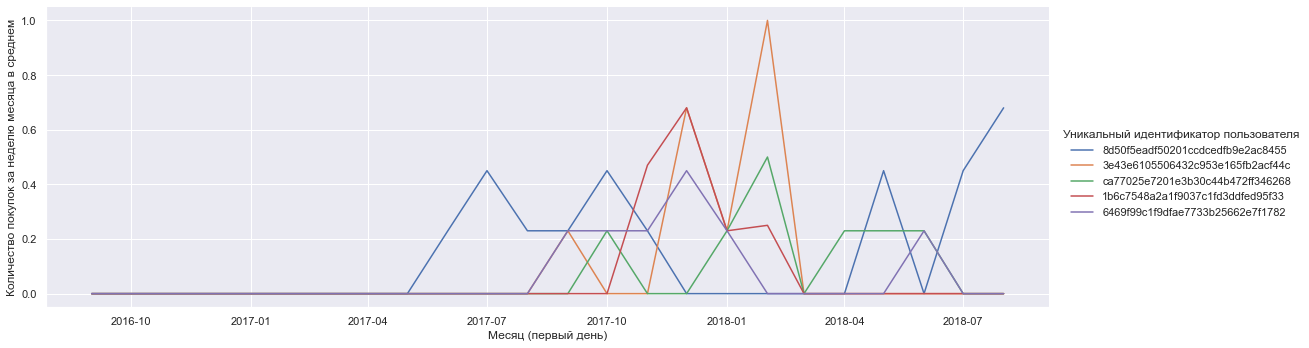

In [148]:
x_name = 'Месяц (первый день)'
y_name = 'Количество покупок за неделю месяца в среднем'
hue_name = 'Уникальный идентификатор пользователя'

sns.set_theme()
sns.relplot(data=data, x=x_name, y=y_name, hue=hue_name, kind='line',aspect=3)

# 

***

# **Задание 5.** 


## Используя pandas, проведи когортный анализ пользователей. В период с января по декабрь выяви когорту с самым высоким retention на 3й месяц. 

# 

### *Будем рассчитывать метрику Retention (Repeat Purchase Rates) по формуле:*

![Formula](https://www.carrotquest.io/blog/wp-content/uploads/2018/06/CRR.png)

# 

### *1. Выясним заказы за какой период содержатся в датасете orders:*

In [ ]:
orders.order_purchase_timestamp.min()

In [ ]:
orders.order_purchase_timestamp.max()

Выяснили, что они - между сентябрем 2016 и октябрем 2018 включительно.

Это означает, что указанный в задании период с января по декабрь означает период: январь 2017 - декабрь 2017. Так как только он является таким непрерывным периодом среди имеющихся дат в orders.


### *2.Cоздадим когорты - месяц первой покупки :*

In [149]:
cohorts = pd.date_range(start=pd.Timestamp('2017-Jan'), end=pd.Timestamp('2018-Jan'), freq='M')
cohorts

DatetimeIndex(['2017-01-31', '2017-02-28', '2017-03-31', '2017-04-30',
               '2017-05-31', '2017-06-30', '2017-07-31', '2017-08-31',
               '2017-09-30', '2017-10-31', '2017-11-30', '2017-12-31'],
              dtype='datetime64[ns]', freq='M')

In [152]:
# Проверяем число когорт (должно быть 12):

len(cohorts)

12

### *3. Вновь создаем датафрейм с покупками, их датами и уникальными id пользователей, совершивших их:*

In [153]:
buys_by_uniq_id = buys.merge(customers, on='customer_id', how='left')\
                      .rename(columns={'order_id':'buy_id', 'order_purchase_timestamp':'buy_date'})\
                       [['buy_id','buy_date','customer_unique_id']]

buys_by_uniq_id.head()

,buy_id,buy_date,customer_unique_id
0,e481f51cbdc54678b7cc49136f2d6af7,2017-10-02 10:56:33,7c396fd4830fd04220f754e42b4e5bff
1,53cdb2fc8bc7dce0b6741e2150273451,2018-07-24 20:41:37,af07308b275d755c9edb36a90c618231
2,47770eb9100c2d0c44946d9cf07ec65d,2018-08-08 08:38:49,3a653a41f6f9fc3d2a113cf8398680e8
3,949d5b44dbf5de918fe9c16f97b45f8a,2017-11-18 19:28:06,7c142cf63193a1473d2e66489a9ae977
4,ad21c59c0840e6cb83a9ceb5573f8159,2018-02-13 21:18:39,72632f0f9dd73dfee390c9b22eb56dd6


### *4. Создаем датафрейм, сопоставляющий когортам - уникальные id пользователей, чьи первые покупки пришлись на месяца из когорт:*

1. Сопоставим абсолютно каждому пользователю магазина - дату его первой покупки (последний день месяца первой покупки):

In [163]:
first_buy_date = buys_by_uniq_id.groupby('customer_unique_id', as_index=False)\
                 .agg({'buy_date':'min'})\
                 .rename(columns={'buy_date':'first_buy_date'})

first_buy_date.first_buy_date = first_buy_date.first_buy_date.apply(lambda date: date.ceil('1D') + pd.offsets.MonthEnd(1))

first_buy_date.head()

,customer_unique_id,first_buy_date
0,0000366f3b9a7992bf8c76cfdf3221e2,2018-05-31
1,0000b849f77a49e4a4ce2b2a4ca5be3f,2018-05-31
2,0000f46a3911fa3c0805444483337064,2017-03-31
3,0000f6ccb0745a6a4b88665a16c9f078,2017-10-31
4,0004aac84e0df4da2b147fca70cf8255,2017-11-30


2. Сгуруппируем пользователей по месяцам их первой покупки:

In [164]:
id_set_by_1stbuy = first_buy_date.groupby('first_buy_date', as_index=False).agg({'customer_unique_id':lambda x: x.to_list()})\
                                  .rename(columns={'customer_unique_id':'customer_uniq_id_set'})

# Преобразуем списки пользователей в множетства, чтобы ликвидировать возможные повторы и для дальнейших вычислений:
id_set_by_1stbuy.customer_uniq_id_set = id_set_by_1stbuy.customer_uniq_id_set.apply(lambda llist: set(llist))

id_set_by_1stbuy.head()

,first_buy_date,customer_uniq_id_set
0,2016-09-30,{830d5b7aaa3b6f1e9ad63703bec97d23}
1,2016-10-31,"{b39c8c284dd7875b68a31449852cc76a, 247c8264f85..."
2,2016-12-31,{f7b981e8a280e455ac3cbe0d5d171bd1}
3,2017-01-31,"{e021e698833bdeb89dfef3acb2e91f37, 5286f434259..."
4,2017-02-28,"{622db09504308011ed01e179e89d0925, 602d8c1d6b1..."


3. Создаем желаемый датафрейм:


Отберем из **id_set_by_1stbuy** только пользователей, совершивших первую покупку в 2017 году:

In [165]:
begin_of_2017 = pd.Timestamp('2017')
begin_of_2018 = pd.Timestamp('2018')

begin_by_cohort = id_set_by_1stbuy.query('first_buy_date < @begin_of_2018 and first_buy_date >= @begin_of_2017')\
                                  .rename(columns={'first_buy_date':'cohort', 'customer_uniq_id_set':'begin_set'})\
                                  .sort_values(by='cohort')

begin_by_cohort.head()

,cohort,begin_set
3,2017-01-31,"{e021e698833bdeb89dfef3acb2e91f37, 5286f434259..."
4,2017-02-28,"{622db09504308011ed01e179e89d0925, 602d8c1d6b1..."
5,2017-03-31,"{0ef4d7b991cc74c7c13b540f7d3129a3, 2990f218665..."
6,2017-04-30,"{dba40b853fb8450879147f77b57efcc2, eb28e67c4c0..."
7,2017-05-31,"{7fef4de812315967e0c7b699e88c5753, 1da09dd64e2..."


Убеждаемся, что получившийся датафрейм включает информацию по каждой интересующей когорте (каждому месяцу из 2017):

In [166]:
# Должно быть 12:

len(begin_by_cohort)

12

#### *Столбец begin_set отражает множества (количества) клиентов на начало периода (в контексте показателя Retention)*

# 

### *5. Узнаем количество клиентов на конец периода в 3 месяца для каждой когорты:*

Для этого узнаем множества клиентов для каждой когорты, которые совершили покупку в течение третьего месяца.

Мы ведем отчет месяцев - с последнего дня каждого месяца, т.к. только на последнем дне можно окончательно судить кто совершил покупки за данный месяц.

1. Сопоставим каждому месяцу - множество пользователей, которые совершили хотя бы 1 покупку в течение него:

In [171]:
#Сопоставляем каждому уник. клиенту - его покупки и его месяц (последний ден месяца):

buys_by_uniq_id = buys.merge(customers, on='customer_id', how='left')\
                      .rename(columns={'order_id':'buy_id', 'order_purchase_timestamp':'buy_date'})\
                       [['buy_id','buy_date','customer_unique_id']]


In [172]:
buys_by_uniq_id

,buy_id,buy_date,customer_unique_id
0,e481f51cbdc54678b7cc49136f2d6af7,2017-10-02 10:56:33,7c396fd4830fd04220f754e42b4e5bff
1,53cdb2fc8bc7dce0b6741e2150273451,2018-07-24 20:41:37,af07308b275d755c9edb36a90c618231
2,47770eb9100c2d0c44946d9cf07ec65d,2018-08-08 08:38:49,3a653a41f6f9fc3d2a113cf8398680e8
3,949d5b44dbf5de918fe9c16f97b45f8a,2017-11-18 19:28:06,7c142cf63193a1473d2e66489a9ae977
4,ad21c59c0840e6cb83a9ceb5573f8159,2018-02-13 21:18:39,72632f0f9dd73dfee390c9b22eb56dd6
...,...,...,...
96454,9c5dedf39a927c1b2549525ed64a053c,2017-03-09 09:54:05,6359f309b166b0196dbf7ad2ac62bb5a
96455,63943bddc261676b46f01ca7ac2f7bd8,2018-02-06 12:58:58,da62f9e57a76d978d02ab5362c509660
96456,83c1379a015df1e13d02aae0204711ab,2017-08-27 14:46:43,737520a9aad80b3fbbdad19b66b37b30
96457,11c177c8e97725db2631073c19f07b62,2018-01-08 21:28:27,5097a5312c8b157bb7be58ae360ef43c


In [175]:
# Заменяем столбец buy_date на месяц первой покупки (последний день месяца):

buys_by_uniq_id.buy_date = buys_by_uniq_id.buy_date.apply(lambda date: date.ceil('1D') + pd.offsets.MonthEnd(1))

In [176]:
buys_by_uniq_id.head()

,buy_id,buy_date,customer_unique_id
0,e481f51cbdc54678b7cc49136f2d6af7,2017-11-30,7c396fd4830fd04220f754e42b4e5bff
1,53cdb2fc8bc7dce0b6741e2150273451,2018-08-31,af07308b275d755c9edb36a90c618231
2,47770eb9100c2d0c44946d9cf07ec65d,2018-09-30,3a653a41f6f9fc3d2a113cf8398680e8
3,949d5b44dbf5de918fe9c16f97b45f8a,2017-12-31,7c142cf63193a1473d2e66489a9ae977
4,ad21c59c0840e6cb83a9ceb5573f8159,2018-03-31,72632f0f9dd73dfee390c9b22eb56dd6


2. Сгруппируем пользователей в множества по месяцам их покупок:

In [177]:
id_set_by_buy = buys_by_uniq_id.groupby('buy_date', as_index=False).agg({'customer_unique_id':lambda x: x.to_list()})\
                               .rename(columns={'customer_unique_id':'customer_uniq_id_set',
                                                'buy_date':'buy_month'})

id_set_by_buy.customer_uniq_id_set = id_set_by_buy.customer_uniq_id_set.apply(lambda llist: set(llist))

id_set_by_buy.head()

,buy_month,customer_uniq_id_set
0,2016-10-31,{830d5b7aaa3b6f1e9ad63703bec97d23}
1,2016-11-30,"{b39c8c284dd7875b68a31449852cc76a, 94e5ea5a8c1..."
2,2017-01-31,{f7b981e8a280e455ac3cbe0d5d171bd1}
3,2017-02-28,"{e021e698833bdeb89dfef3acb2e91f37, 5286f434259..."
4,2017-03-31,"{622db09504308011ed01e179e89d0925, ee656a283b8..."


Отражены 23 месяца:

In [178]:
len(id_set_by_buy)

23

3. Фильтруем из полученного датафрейма только те покупки, которые совершались в месяцы, являющиеся третьими для наших когорт:

Определим такие месяцы:

In [179]:
#Наши изначальные когорты:

cohorts

DatetimeIndex(['2017-01-31', '2017-02-28', '2017-03-31', '2017-04-30',
               '2017-05-31', '2017-06-30', '2017-07-31', '2017-08-31',
               '2017-09-30', '2017-10-31', '2017-11-30', '2017-12-31'],
              dtype='datetime64[ns]', freq='M')

In [180]:
len(cohorts)

12

In [185]:
# Месяцы, являющиеся третьими для наших когорт:

third_months = list(map(lambda cohort: cohort + pd.offsets.MonthEnd(3), cohorts))

In [186]:
third_months

[Timestamp('2017-04-30 00:00:00', freq='M'),
 Timestamp('2017-05-31 00:00:00', freq='M'),
 Timestamp('2017-06-30 00:00:00', freq='M'),
 Timestamp('2017-07-31 00:00:00', freq='M'),
 Timestamp('2017-08-31 00:00:00', freq='M'),
 Timestamp('2017-09-30 00:00:00', freq='M'),
 Timestamp('2017-10-31 00:00:00', freq='M'),
 Timestamp('2017-11-30 00:00:00', freq='M'),
 Timestamp('2017-12-31 00:00:00', freq='M'),
 Timestamp('2018-01-31 00:00:00', freq='M'),
 Timestamp('2018-02-28 00:00:00', freq='M'),
 Timestamp('2018-03-31 00:00:00', freq='M')]

In [187]:
min(third_months)

Timestamp('2017-04-30 00:00:00', freq='M')

In [188]:
max(third_months)

Timestamp('2018-03-31 00:00:00', freq='M')

Видим, что третьими для наших когорт являются месяцы с апреля 2017 по февраль 2018.

Поэтому отфильтруем из датафрейма **id_set_by_buy** только покупки совершенные между этими месяцами (включительно):

In [190]:
min_month = min(third_months)
max_month = max(third_months)

end_by_thirdmonth = id_set_by_buy.query('buy_month >= @min_month and buy_month <= @max_month')\
                                 .rename(columns={'buy_month':'third_month', 'customer_uniq_id_set':'end_set'})\
                                 .sort_values(by='third_month')

end_by_thirdmonth.head()

,third_month,end_set
5,2017-04-30,"{0ef4d7b991cc74c7c13b540f7d3129a3, 2990f218665..."
6,2017-05-31,"{dba40b853fb8450879147f77b57efcc2, eb28e67c4c0..."
7,2017-06-30,"{7fef4de812315967e0c7b699e88c5753, 1da09dd64e2..."
8,2017-07-31,"{3e48bba0b7cb5cecafebde1c1bf0da58, 1cd4ae7e04e..."
9,2017-08-31,"{1da09dd64e235e7c2f29a4faff33535c, 33490faf8ba..."


In [195]:
# Убеждаемся, что количество "третьих" месяцев равно количеству когорт (должно получиться 12):

len(end_by_thirdmonth)

12

# 

### *6. Соединяем полученные 2 датафрейма ***begin_by_cohort*** и ***end_by_thirdmonth***:*

#### *Столбец end_set отражает множества (количества) клиентов на конец третьего месяца:*

In [221]:
general = pd.concat([begin_by_cohort.reset_index(), end_by_thirdmonth.reset_index()], ignore_index=False, axis=1)\
            [['cohort', 'begin_set', 'third_month', 'end_set']]

general

,cohort,begin_set,third_month,end_set
0,2017-01-31,"{e021e698833bdeb89dfef3acb2e91f37, 5286f434259...",2017-04-30,"{0ef4d7b991cc74c7c13b540f7d3129a3, 2990f218665..."
1,2017-02-28,"{622db09504308011ed01e179e89d0925, 602d8c1d6b1...",2017-05-31,"{dba40b853fb8450879147f77b57efcc2, eb28e67c4c0..."
2,2017-03-31,"{0ef4d7b991cc74c7c13b540f7d3129a3, 2990f218665...",2017-06-30,"{7fef4de812315967e0c7b699e88c5753, 1da09dd64e2..."
3,2017-04-30,"{dba40b853fb8450879147f77b57efcc2, eb28e67c4c0...",2017-07-31,"{3e48bba0b7cb5cecafebde1c1bf0da58, 1cd4ae7e04e..."
4,2017-05-31,"{7fef4de812315967e0c7b699e88c5753, 1da09dd64e2...",2017-08-31,"{1da09dd64e235e7c2f29a4faff33535c, 33490faf8ba..."
5,2017-06-30,"{3e48bba0b7cb5cecafebde1c1bf0da58, 1cd4ae7e04e...",2017-09-30,"{96caa408e9ca13ba035233f9ad9fd15f, 3d5828dbc0f..."
6,2017-07-31,"{33490faf8baed348c792ac23f8184488, 1bb511ed18c...",2017-10-31,"{508147067e5a8fb40c9e47ba28aab934, 8edc3521853..."
7,2017-08-31,"{96caa408e9ca13ba035233f9ad9fd15f, 3d5828dbc0f...",2017-11-30,"{2d2b42b5afdd4aef166806ef0c564c47, dc07569e18b..."
8,2017-09-30,"{508147067e5a8fb40c9e47ba28aab934, 8edc3521853...",2017-12-31,"{cb36a3e948bd39985972470cffff43c5, d00cb931570..."
9,2017-10-31,"{2d2b42b5afdd4aef166806ef0c564c47, dc07569e18b...",2018-01-31,"{5b47ada4d688a13c2cdc4639e332c272, 7fc951e458a..."


### *7. Считаем Customer Retention Rate за 3 месяца для наших когорт:*

1. Добавляем столбец удержанных в течение 3 месяцев клиентов (клиенты которые сделали первую покупку 3 месяца назад и сделали ее спустя 3 месяца):

In [222]:
#Применяем метод пересечения множеств begin_set и end_set:

general['common_set'] = [general.begin_set[i].intersection(general.end_set[i]) for i in range(len(general))]

In [223]:
general.head()

,cohort,begin_set,third_month,end_set,common_set
0,2017-01-31,"{e021e698833bdeb89dfef3acb2e91f37, 5286f434259...",2017-04-30,"{0ef4d7b991cc74c7c13b540f7d3129a3, 2990f218665...",{bc2387c48428a2e128eaa3d5b18b3591}
1,2017-02-28,"{622db09504308011ed01e179e89d0925, 602d8c1d6b1...",2017-05-31,"{dba40b853fb8450879147f77b57efcc2, eb28e67c4c0...","{e5bdbd18812e42788e7cbad7058fc0ab, a5c806ebe5b..."
2,2017-03-31,"{0ef4d7b991cc74c7c13b540f7d3129a3, 2990f218665...",2017-06-30,"{7fef4de812315967e0c7b699e88c5753, 1da09dd64e2...","{015557c9912277312b9073947804a7ba, cbebce165db..."
3,2017-04-30,"{dba40b853fb8450879147f77b57efcc2, eb28e67c4c0...",2017-07-31,"{3e48bba0b7cb5cecafebde1c1bf0da58, 1cd4ae7e04e...","{8d6512fa0e1c5cdbd789b956de79fe2f, a38b86dce31..."
4,2017-05-31,"{7fef4de812315967e0c7b699e88c5753, 1da09dd64e2...",2017-08-31,"{1da09dd64e235e7c2f29a4faff33535c, 33490faf8ba...","{1da09dd64e235e7c2f29a4faff33535c, 05e52c1f96f..."


2. Преобразуем столбцы begin_set, end_set, common_set в количества пользователей внутри их множеств:

In [224]:
# Заменяем множества пользователей на количество пользователей в этих множествах:

general.begin_set = general.begin_set.apply(lambda id_set: len(id_set))
general.end_set = general.end_set.apply(lambda id_set: len(id_set))
general.common_set = general.common_set.apply(lambda id_set: len(id_set))

In [225]:
# Переименовываем столбцы:

general_by_qty = general.rename(columns={'begin_set':'begin_qty', 'end_set':'end_qty', 'common_set':'retentioned_qty'})

general_by_qty

,cohort,begin_qty,third_month,end_qty,retentioned_qty
0,2017-01-31,610,2017-04-30,2462,1
1,2017-02-28,1641,2017-05-31,2281,4
2,2017-03-31,2457,2017-06-30,3401,8
3,2017-04-30,2263,2017-07-31,3092,5
4,2017-05-31,3372,2017-08-31,3751,17
5,2017-06-30,3052,2017-09-30,4056,13
6,2017-07-31,3701,2017-10-31,4182,11
7,2017-08-31,4000,2017-11-30,4337,16
8,2017-09-30,4102,2017-12-31,6909,20
9,2017-10-31,4249,2018-01-31,5851,12


Таким образом, полученные значения отражают:
- begin_qty - число пользователей вначале периода
- end_qty - число пользователей в конце периода
- retentioned_qty - число удержанных пользователей

3. Считаем метрику Customer Retention Rate за три месяца для наших когорт:

In [226]:
general_by_qty['CRR_percentage'] = round((general_by_qty.retentioned_qty / general_by_qty.begin_qty)*100, 3)

4. Оставляем только столбцы - когорты и CRR:

In [229]:
# Преобразуем столбец cohort в название месяца словами (для читабельности):


general_by_qty['cohort'] = general_by_qty['cohort'].apply(lambda x: x.strftime('%b %Y'))

In [230]:
general_by_qty[['cohort', 'CRR_percentage']]

,cohort,CRR_percentage
0,Jan 2017,0.164
1,Feb 2017,0.244
2,Mar 2017,0.326
3,Apr 2017,0.221
4,May 2017,0.504
5,Jun 2017,0.426
6,Jul 2017,0.297
7,Aug 2017,0.400
8,Sep 2017,0.488
9,Oct 2017,0.282


### *8. Узнаем когорту с самым высоким retention на 3й месяц (ОТВЕТ):*

In [233]:
# Сортируем когорты по убыванию CRR:

general_by_qty.sort_values(by='CRR_percentage', ascending=False)\
              [['cohort', 'CRR_percentage']]

,cohort,CRR_percentage
4,May 2017,0.504
8,Sep 2017,0.488
5,Jun 2017,0.426
7,Aug 2017,0.400
2,Mar 2017,0.326
6,Jul 2017,0.297
10,Nov 2017,0.295
9,Oct 2017,0.282
11,Dec 2017,0.279
1,Feb 2017,0.244


### *ОТВЕТ: Май 2017*

# 

***

# **Задание 5.**

## Построй RFM-сегментацию пользователей, чтобы качественно оценить свою аудиторию. 

### *1. Вновь обращаемся к датафрейму с покупками:*

In [242]:
buys.head()

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26


Отфильтруем из него только покупки, совершенные за последние 365 дней, т.к. будем проводить RFM-анализ за последний год:

In [253]:
# Выясним дату проведения анализа (дата относительно которой берем последние 365 дней):

now = buys.order_purchase_timestamp.max() + pd.Timedelta(days=1)

now

Timestamp('2018-08-30 15:00:37')

In [250]:
# Дата - год назад от момента составления датафрейма

min_date = now - pd.Timedelta(days=365)

min_date

Timestamp('2017-08-30 15:00:37')

In [252]:
# Покупки за последний год:

buys_last_year = buys.query('order_purchase_timestamp > @min_date')

buys_last_year.head()

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26


In [251]:
# Количество покупок за последний год:

len(buys_last_year)

74417

### *2. Cопоставляем каждой из покупок за год - пользователя, совершившую ее и общую сумму покупки:*

1. Сопоставляем каждой покупке - уникальный id пользователя:

In [258]:
id_by_buy_365 = buys_last_year.merge(customers, on='customer_id')\
                              [['order_id', 'order_purchase_timestamp', 'customer_unique_id']]

id_by_buy_365.head()

,order_id,order_purchase_timestamp,customer_unique_id
0,e481f51cbdc54678b7cc49136f2d6af7,2017-10-02 10:56:33,7c396fd4830fd04220f754e42b4e5bff
1,53cdb2fc8bc7dce0b6741e2150273451,2018-07-24 20:41:37,af07308b275d755c9edb36a90c618231
2,47770eb9100c2d0c44946d9cf07ec65d,2018-08-08 08:38:49,3a653a41f6f9fc3d2a113cf8398680e8
3,949d5b44dbf5de918fe9c16f97b45f8a,2017-11-18 19:28:06,7c142cf63193a1473d2e66489a9ae977
4,ad21c59c0840e6cb83a9ceb5573f8159,2018-02-13 21:18:39,72632f0f9dd73dfee390c9b22eb56dd6


In [261]:
# Проверяем количество покупок за последний последний год (должно быть 74417):

len(id_by_buy_365)

74417

2. Сопоставляем каждой покупке - ее стоимость:

In [265]:
# Сопоставим каждому ЗАКАЗУ - его общие стоимость:

cost_by_order = order_details.groupby('order_id',as_index=False).agg({'price':'sum'})\
                             .rename(columns={'price':'total_price'})

cost_by_order.head()

,order_id,total_price
0,00010242fe8c5a6d1ba2dd792cb16214,58.90
1,00018f77f2f0320c557190d7a144bdd3,239.90
2,000229ec398224ef6ca0657da4fc703e,199.00
3,00024acbcdf0a6daa1e931b038114c75,12.99
4,00042b26cf59d7ce69dfabb4e55b4fd9,199.90


In [266]:
# Сопоставляем только ПОКУПКАМ - их общие стоимости:

buys_365 = id_by_buy_365.merge(cost_by_order, on='order_id', how='left')\
                        .rename(columns={'order_id':'buy_id', 'order_purchase_timestamp':'buy_date'})

buys_365.head()

,buy_id,buy_date,customer_unique_id,total_price
0,e481f51cbdc54678b7cc49136f2d6af7,2017-10-02 10:56:33,7c396fd4830fd04220f754e42b4e5bff,29.99
1,53cdb2fc8bc7dce0b6741e2150273451,2018-07-24 20:41:37,af07308b275d755c9edb36a90c618231,118.70
2,47770eb9100c2d0c44946d9cf07ec65d,2018-08-08 08:38:49,3a653a41f6f9fc3d2a113cf8398680e8,159.90
3,949d5b44dbf5de918fe9c16f97b45f8a,2017-11-18 19:28:06,7c142cf63193a1473d2e66489a9ae977,45.00
4,ad21c59c0840e6cb83a9ceb5573f8159,2018-02-13 21:18:39,72632f0f9dd73dfee390c9b22eb56dd6,19.90


### *3. Считаем Recency и Frequency для каждого пользователя из тех, кто сделал покупку за последние 365 дней:*

In [267]:
fr = buys_365.groupby('customer_unique_id',as_index=False)\
             .agg({'buy_id':'count',
                   'buy_date':lambda x: (now - x.max()).days})\
             .rename(columns={'buy_id':'Frequency', 'buy_date':'Recency'})\
             .sort_values(by=['Frequency','Recency'], ascending=[False, True])

     
fr.head()

,customer_unique_id,Frequency,Recency
39862,8d50f5eadf50201ccdcedfb9e2ac8455,11,9
17635,3e43e6105506432c953e165fb2acf44c,9,183
28401,6469f99c1f9dfae7733b25662e7f1782,7,63
57375,ca77025e7201e3b30c44b472ff346268,7,90
7724,1b6c7548a2a1f9037c1fd3ddfed95f33,7,197


### *4. Считаем Monetary для каждого пользователя из тех, кто сделал покупку за последние 365 дней:*

In [268]:
m = buys_365.groupby('customer_unique_id',as_index=False)\
    .agg({'total_price':'sum'})\
    .rename(columns={'total_price':'Monetary'})\
    .sort_values(by='Monetary', ascending=False)

m.head()

,customer_unique_id,Monetary
2818,0a0a92112bd4c708ca5fde585afaa872,13440.0
33421,763c8b1c9c68a0229c42c9fc6f662b93,7160.0
19673,459bef486812aa25204be022145caa62,6729.0
18131,4007669dec559734d6f53e029e360987,5934.6
20604,48e1ac109decbb87765a3eade6854098,4590.0


### *5. Объединяем Monetary, Recency и Frequency в один датафрейм:*

In [272]:
rfm = fr.merge(m)

rfm.head()

,customer_unique_id,Frequency,Recency,Monetary
0,8d50f5eadf50201ccdcedfb9e2ac8455,11,9,440.94
1,3e43e6105506432c953e165fb2acf44c,9,183,1000.85
2,6469f99c1f9dfae7733b25662e7f1782,7,63,664.20
3,ca77025e7201e3b30c44b472ff346268,7,90,806.61
4,1b6c7548a2a1f9037c1fd3ddfed95f33,7,197,809.21


Проверяем учтены ли все необходимые пользователи:

In [273]:
# Количество уникальных пользователей в датафрейме покупок за последний год:

id_by_buy_365.customer_unique_id.nunique()

72445

In [275]:
# Количество уникальных пользователей в датафрейме RFM (должно быть 72445):

rfm.customer_unique_id.nunique()

72445

### *6. Разбиваем наши парметры на интервалы: по 20-процентным квантилям аудитории:*

Выберем этот способ сегментации, так как полученные с его помощью интервалы являются равномерными не по значениям параметров, а по долям людей, входящих в них. 

Так нам удастся в каждый интервал "отмерить" равное число пользователей и, таким образом, равномерно распределить интервалы между их количеством.

Использование квантилей является более гибким, поскольку диапазоны будут адаптироваться к данным и будут работать в случае каких-либо изменений в ожидаемом поведении клиентов.

1. Создадим словарь словарей со значениями 20-процентных квантилей для каждого RFM-параметра:

In [276]:
quintiles = rfm[['Recency', 'Frequency', 'Monetary']].quantile([.2, .4, .6, .8]).to_dict()

quintiles

{'Recency': {0.2: 71.0, 0.4: 139.0, 0.6: 204.0, 0.8: 275.0},
 'Frequency': {0.2: 1.0, 0.4: 1.0, 0.6: 1.0, 0.8: 1.0},
 'Monetary': {0.2: 39.9, 0.4: 69.9, 0.6: 109.98, 0.8: 179.7}}

2. Затем пишем функции для присвоения рангов от 1 до 5:

In [277]:
## Каждому квантилю соответсвует свой ранг:

# Функция присвоения ранга для Recency:
def r_score(x):
    if x <= quintiles['Recency'][.2]:
        return 5
    elif x <= quintiles['Recency'][.4]:
        return 4
    elif x <= quintiles['Recency'][.6]:
        return 3
    elif x <= quintiles['Recency'][.8]:
        return 2
    else:
        return 1

# Функция присвоения ранга для Frequency и Monetary:
def fm_score(x, c):
    if x <= quintiles[c][.2]:
        return 1
    elif x <= quintiles[c][.4]:
        return 2
    elif x <= quintiles[c][.6]:
        return 3
    elif x <= quintiles[c][.8]:
        return 4
    else:
        return 5  

3. Считаем значения рангов для каждого пользователя:

In [280]:
# Создаем столбцы с рангами каждой из трех метрик:

rfm['R'] = rfm['Recency'].apply(lambda x: r_score(x))
rfm['F'] = rfm['Frequency'].apply(lambda x: fm_score(x, 'Frequency'))
rfm['M'] = rfm['Monetary'].apply(lambda x: fm_score(x, 'Monetary'))

In [281]:
rfm.head()

,customer_unique_id,Frequency,Recency,Monetary,R,F,M
0,8d50f5eadf50201ccdcedfb9e2ac8455,11,9,440.94,5,5,5
1,3e43e6105506432c953e165fb2acf44c,9,183,1000.85,3,5,5
2,6469f99c1f9dfae7733b25662e7f1782,7,63,664.20,5,5,5
3,ca77025e7201e3b30c44b472ff346268,7,90,806.61,4,5,5
4,1b6c7548a2a1f9037c1fd3ddfed95f33,7,197,809.21,3,5,5


### *7. Cчитаем метрику RFM для каждого пользователя:*

Объединяем оценки (ранги) R, F и M в общую метрику RFM для пользователей:

In [282]:
rfm['RFM_score'] = rfm['R'].map(str) + rfm['F'].map(str) + rfm['M'].map(str)

rfm.head()

,customer_unique_id,Frequency,Recency,Monetary,R,F,M,RFM_score
0,8d50f5eadf50201ccdcedfb9e2ac8455,11,9,440.94,5,5,5,555
1,3e43e6105506432c953e165fb2acf44c,9,183,1000.85,3,5,5,355
2,6469f99c1f9dfae7733b25662e7f1782,7,63,664.20,5,5,5,555
3,ca77025e7201e3b30c44b472ff346268,7,90,806.61,4,5,5,455
4,1b6c7548a2a1f9037c1fd3ddfed95f33,7,197,809.21,3,5,5,355


### *8. Разобьем наших пользователей на сегменты по их RFM-метрике:*

Оценки RFM дают нам $$5^3 = 125$$  сегментов. С которым затруднительно работать.

Отберем только 11 сегментов на основе показателей R и F. Вот описание сегментов:

- ***Champions***	- Покупали недавно, покупают часто и тратят больше всего.
- ***Loyal Customers***	- Покупают на регулярной основе. Реагируют на рекламные акции.
- ***Potential Loyalist***- Недавние клиенты со средней частотой.
- ***Recent Customers***	- Покупали совсем недавно, но не часто.
- ***Promising***	- Покупали недавно, но не потратили много.
- ***Customers*** - Требует внимания. Выше средней Recency, Frequency и Monetary. Но могли покупать и не так давно.
- ***About To Sleep***	- Ниже средней давности и частоты. Потеряем их, если не активизируемповторно.
- ***At Risk***	- Покупал часто, но давно. Нужно вернуть их!
- ***Can’t Lose Them***	- Когда-то часто покупал, но давно не возвращался в магазин.
- ***Hibernating***	- Последняя покупка была давно и совершено мало заказов. Возможно клиент потерян.

Результирующая матрица выглядит следующим образом:

![matrix](https://guillaume-martin.github.io/images/rfm-segments.png)

Разбиваем наших пользователей на сегменты по их RFM-метрикам:

In [283]:
segt_map = {
    r'[1-2][1-2]': 'hibernating',
    r'[1-2][3-4]': 'at risk',
    r'[1-2]5': 'can\'t loose',
    r'3[1-2]': 'about to sleep',
    r'33': 'need attention',
    r'[3-4][4-5]': 'loyal customers',
    r'41': 'promising',
    r'51': 'new customers',
    r'[4-5][2-3]': 'potential loyalists',
    r'5[4-5]': 'champions'
}

rfm['Segment'] = rfm['R'].map(str) + rfm['F'].map(str)
rfm['Segment'] = rfm['Segment'].replace(segt_map, regex=True)

rfm.head()

,customer_unique_id,Frequency,Recency,Monetary,R,F,M,RFM_score,Segment
0,8d50f5eadf50201ccdcedfb9e2ac8455,11,9,440.94,5,5,5,555,champions
1,3e43e6105506432c953e165fb2acf44c,9,183,1000.85,3,5,5,355,loyal customers
2,6469f99c1f9dfae7733b25662e7f1782,7,63,664.20,5,5,5,555,champions
3,ca77025e7201e3b30c44b472ff346268,7,90,806.61,4,5,5,455,loyal customers
4,1b6c7548a2a1f9037c1fd3ddfed95f33,7,197,809.21,3,5,5,355,loyal customers


### *9. Визуализируем полученные результаты:*

1. Количественное  распределение по сегментам:

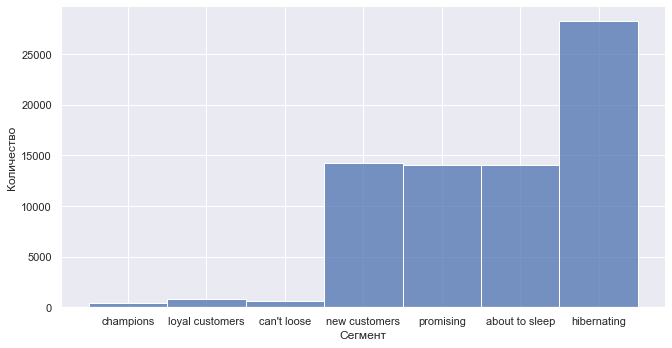

In [284]:
sns.set_theme()
ax = sns.displot(data=rfm, x='Segment', aspect=1.9)
ax.set(xlabel='Сегмент',
       ylabel='Количество')

sns.despine()

Видим, что в нашем магазине очень много "спящих" и неактивных клиентов. Нам срочно необходимо принимать по их активизации и возвращению.

2. Количественное  распределение по величине  RFM-метрики:

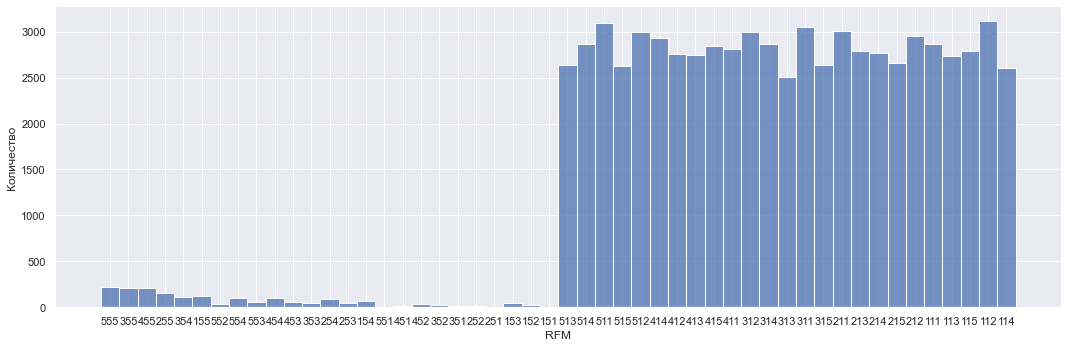

In [285]:
sns.set_theme()
ax2 = sns.displot(data=rfm, x='RFM_score',aspect=3)
ax2.set(xlabel='RFM',
       ylabel='Количество')

sns.despine()

Видим то же самое - в нашем магазине большая часть клиентов находится на грани потери.

3. Количественное  распределение по отдельным  параметрам RFM-метрики:

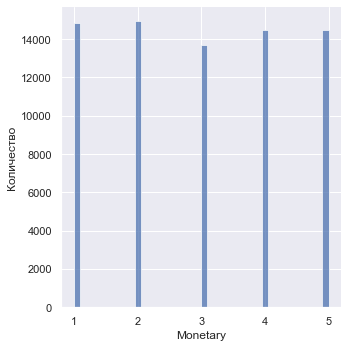

In [286]:
ax3 = sns.displot(data=rfm.M, aspect=1)
ax3.set(xlabel='Monetary',
       ylabel='Количество')

sns.despine()

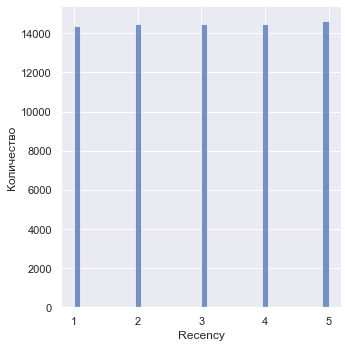

In [287]:
ax4 = sns.displot(data=rfm.R, aspect=1)
ax4.set(xlabel='Recency',
       ylabel='Количество')

sns.despine()

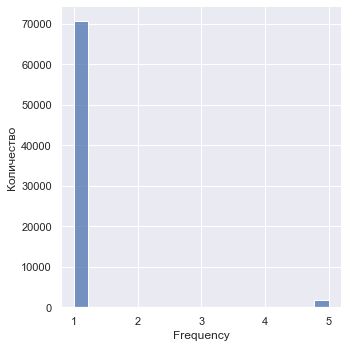

In [288]:
ax5 = sns.displot(data=rfm.F, aspect=1)
ax5.set(xlabel='Frequency',
       ylabel='Количество')

sns.despine()

Видим, что все параметры распределены равномерно, кроме Frequency. У него - сильный сдвиг в сторону 1.